# Heart Disease 

In [26]:
import numpy as np
import pandas as pd
import csv
import math
from math import exp, log
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
sns.set_theme()

# FILEPATH
import matplotlib.pyplot as plt

# Process Data

## Import Data

In [2]:
# Read the CSV file into a DataFrame
data = pd.read_csv('CVD_cleaned.csv')

In [3]:
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


## Data Info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

In [5]:
unique_values = {}
for col in data.columns:
    unique_values[col] = data[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
General_Health,5
Checkup,5
Exercise,2
Heart_Disease,2
Skin_Cancer,2
Other_Cancer,2
Depression,2
Diabetes,4
Arthritis,2
Sex,2


In [6]:
data.duplicated().sum()

np.int64(80)

In [7]:
data.drop_duplicates(inplace = True)

In [8]:
data.duplicated().sum()

np.int64(0)

## EDA

In [9]:
# Summary statistics
summary_stats = data.describe()
print(summary_stats)

         Height_(cm)    Weight_(kg)            BMI  Alcohol_Consumption  \
count  308774.000000  308774.000000  308774.000000        308774.000000   
mean      170.615220      83.590399      28.626813             5.097557   
std        10.658452      21.344664       6.522810             8.200434   
min        91.000000      24.950000      12.020000             0.000000   
25%       163.000000      68.040000      24.210000             0.000000   
50%       170.000000      81.650000      27.440000             1.000000   
75%       178.000000      95.250000      31.850000             6.000000   
max       241.000000     293.020000      99.330000            30.000000   

       Fruit_Consumption  Green_Vegetables_Consumption  \
count      308774.000000                 308774.000000   
mean           29.834290                     15.109517   
std            24.877812                     14.926912   
min             0.000000                      0.000000   
25%            12.000000          

In [10]:
data.columns

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')

In [11]:
numerical= data.drop(['Heart_Disease'], axis=1).select_dtypes('number').columns
categorical = data.select_dtypes('object').columns

print(f'Numerical Columns:  {data[numerical].columns}')
print('\n')
print(f'Categorical Columns: {data[categorical].columns}')

Numerical Columns:  Index(['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
       'Fruit_Consumption', 'Green_Vegetables_Consumption',
       'FriedPotato_Consumption'],
      dtype='object')


Categorical Columns: Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Smoking_History'],
      dtype='object')


In [12]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization
le = LabelEncoder()
df1 = data.copy(deep = True)

# LabelEncoder Categorical values 
for col in categorical:
	df1[col] = le.fit_transform(df1[col])

df1.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,3,2,0,0,0,0,0,0,1,0,10,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,4,4,0,1,0,0,0,2,0,0,10,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,4,4,1,0,0,0,0,2,0,0,8,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,3,4,1,1,0,0,0,2,0,1,11,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,2,4,0,0,0,0,0,0,0,1,12,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0


In [13]:
# Correlation matrix
correlation_matrix = df1.corr()
print(correlation_matrix)

                              General_Health   Checkup  Exercise  \
General_Health                      1.000000  0.027431  0.036864   
Checkup                             0.027431  1.000000 -0.029803   
Exercise                            0.036864 -0.029803  1.000000   
Heart_Disease                      -0.020640  0.083513 -0.096321   
Skin_Cancer                         0.020864  0.079313 -0.003963   
Other_Cancer                        0.004456  0.086779 -0.054363   
Depression                          0.002313  0.035674 -0.084673   
Diabetes                           -0.025157  0.127858 -0.136589   
Arthritis                           0.014013  0.150225 -0.124785   
Sex                                -0.013733 -0.100058  0.059355   
Age_Category                        0.032378  0.223116 -0.122334   
Height_(cm)                         0.001634 -0.088951  0.091622   
Weight_(kg)                         0.014861  0.012043 -0.090121   
BMI                                 0.013967  0.

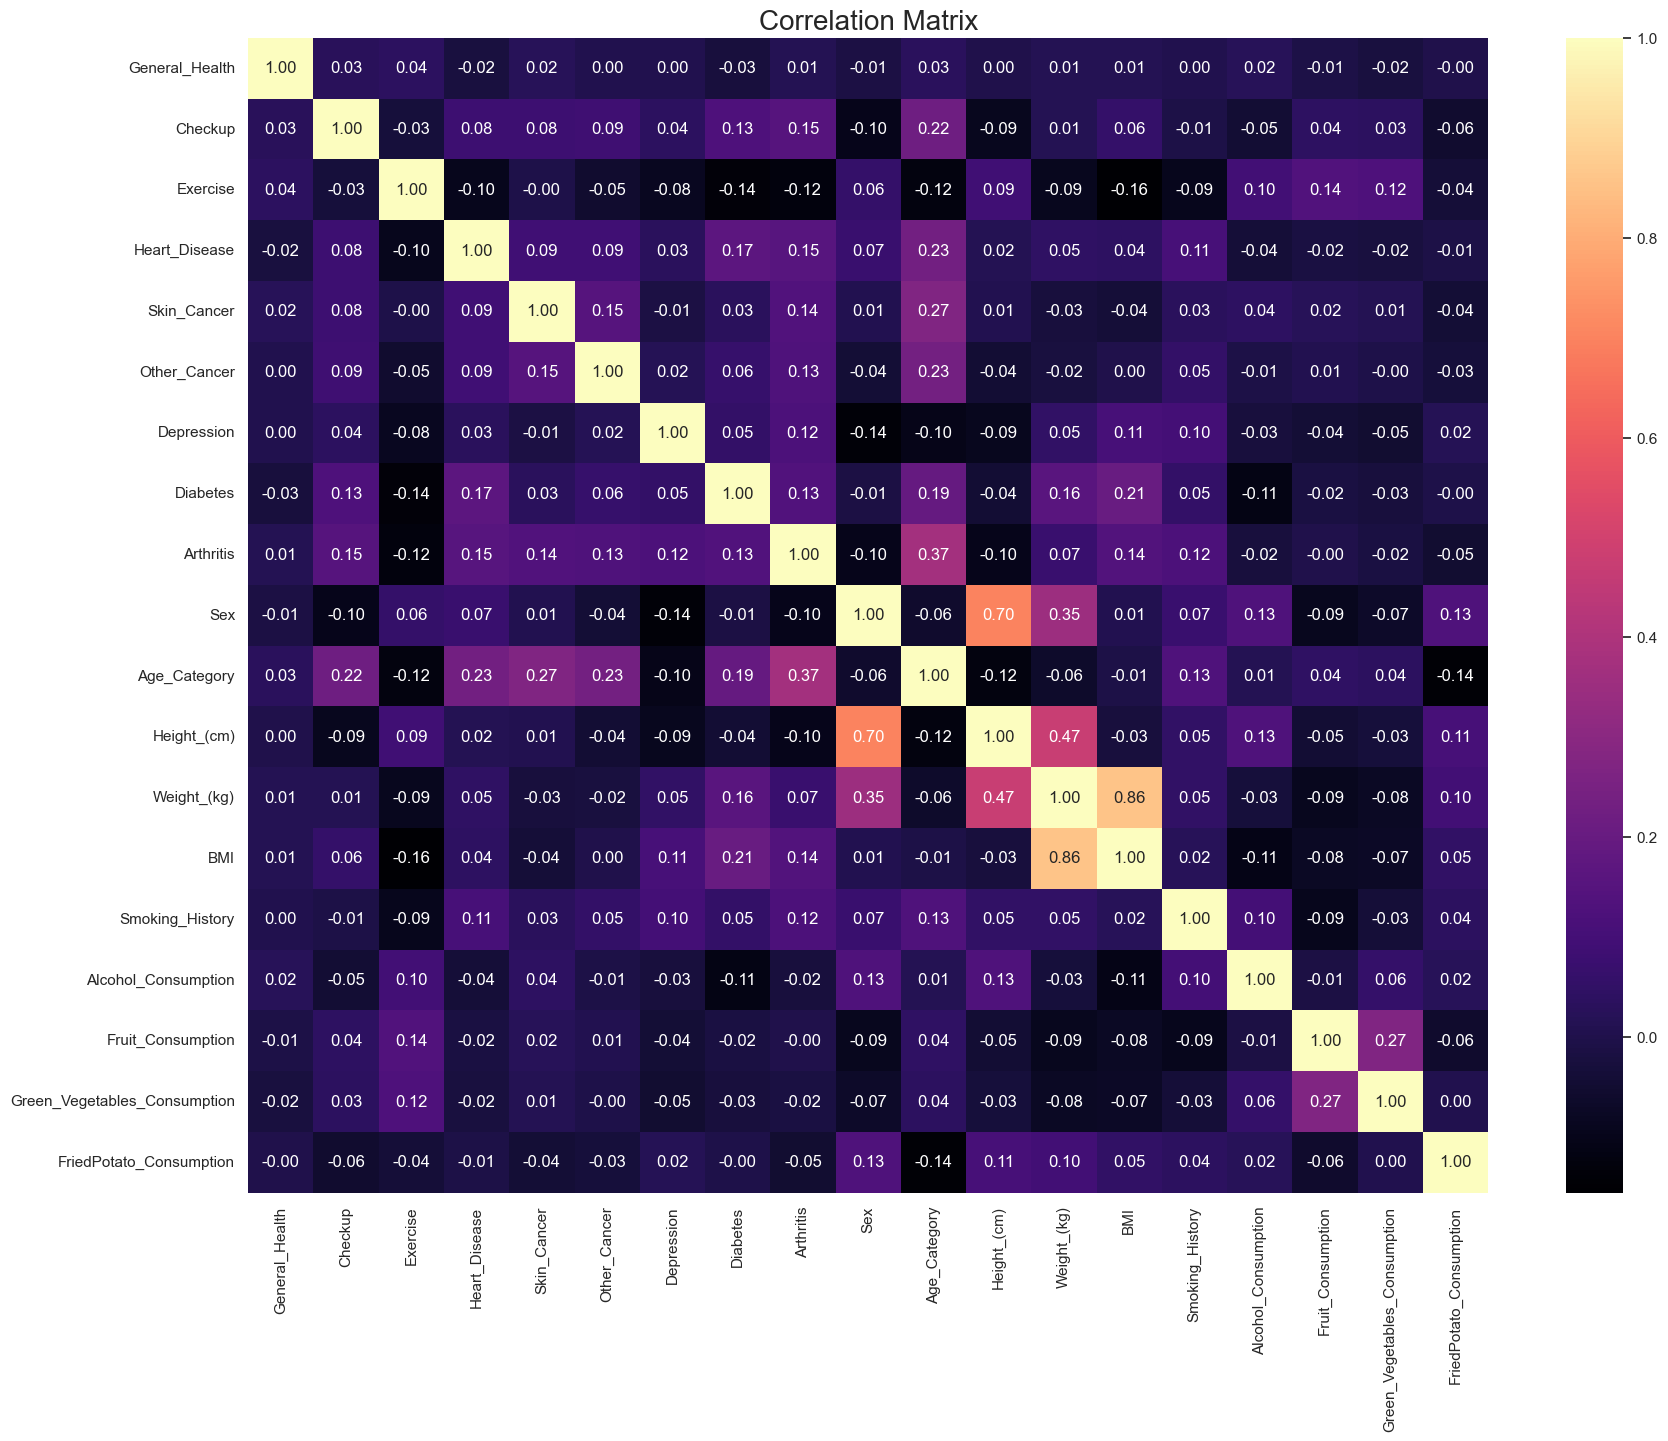

In [14]:
f,ax = plt.subplots(figsize=[20,15])
sns.heatmap(df1.corr(), annot=True, fmt = '.2f', ax=ax, cmap='magma')
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [15]:
hig_corr = df1.corr()
hig_corr_features = hig_corr.index[abs(hig_corr["Heart_Disease"]) >= 0.2]
hig_corr_features

Index(['Heart_Disease', 'Age_Category'], dtype='object')

## Remove outliers

In [16]:
df1.shape

(308774, 19)

In [17]:
df1.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,3,2,0,0,0,0,0,0,1,0,10,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,4,4,0,1,0,0,0,2,0,0,10,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,4,4,1,0,0,0,0,2,0,0,8,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,3,4,1,1,0,0,0,2,0,1,11,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,2,4,0,0,0,0,0,0,0,1,12,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0


In [18]:
# remove outlier by 98% percentile 
for col in numerical:
	q = df1[col].quantile(0.95)
	df1 = df1[df1[col] < q]

df1.shape

(170651, 19)

### Split train/test 

In [19]:
# Separate data features by removing the data label.
X = df1.drop(columns=["Heart_Disease"], axis=1)

# Assign data label to variable y
y = df1.Heart_Disease

y.value_counts()

Heart_Disease
0    156828
1     13823
Name: count, dtype: int64

### Feature Selection

In [20]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k=12)
X_new = selector.fit_transform(X, y)

# Map the selected indices to the feature names
important_features = X.columns[selector.get_support(indices=True)]

# Display the selected features
print(important_features)

Index(['General_Health', 'Checkup', 'Exercise', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Weight_(kg)', 'Smoking_History', 'Alcohol_Consumption',
       'Fruit_Consumption', 'Green_Vegetables_Consumption'],
      dtype='object')


In [21]:
X_selected = pd.DataFrame(X_new, columns=important_features)
X_selected.head()

,General_Health,Checkup,Exercise,Diabetes,Arthritis,Sex,Age_Category,Weight_(kg),Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption
0,3.0,2.0,0.0,0.0,1.0,0.0,10.0,32.66,1.0,0.0,30.0,16.0
1,4.0,4.0,0.0,2.0,0.0,0.0,10.0,77.11,0.0,0.0,30.0,0.0
2,4.0,4.0,1.0,2.0,0.0,0.0,8.0,88.45,0.0,4.0,12.0,3.0
3,1.0,4.0,1.0,0.0,1.0,1.0,8.0,69.85,1.0,0.0,16.0,8.0
4,1.0,4.0,0.0,0.0,0.0,0.0,9.0,72.57,1.0,0.0,12.0,12.0


### Handling imbalance

In [22]:
from imblearn.under_sampling import NearMiss

nm = NearMiss(version=1, n_neighbors=5)

x_sm, y_sm = nm.fit_resample(X_selected, y)

In [23]:
y_sm.value_counts()

Heart_Disease
0    13823
1    13823
Name: count, dtype: int64

In [24]:
x_sm.head()

,General_Health,Checkup,Exercise,Diabetes,Arthritis,Sex,Age_Category,Weight_(kg),Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption
0,2.0,4.0,1.0,0.0,1.0,0.0,12.0,58.97,0.0,0.0,30.0,8.0
1,2.0,4.0,1.0,0.0,1.0,0.0,12.0,58.97,1.0,0.0,30.0,8.0
2,2.0,4.0,1.0,0.0,1.0,0.0,11.0,81.65,0.0,0.0,30.0,4.0
3,2.0,4.0,1.0,0.0,1.0,0.0,11.0,81.65,0.0,0.0,30.0,4.0
4,2.0,4.0,1.0,0.0,1.0,0.0,11.0,81.65,0.0,0.0,30.0,4.0


# Train

## PSO Xgboost

In [28]:
def fitness_function(keys, position,data, cv_splits, SEED):
    d = len(position) # number of dimensions aka number of parameters we are tuning
    X, y = data
    xgboost_param_by_position = dict(zip(keys, position))

    cv_results = cross_validate(
                    estimator=XGBClassifier(learning_rate = 0.1, random_state=SEED, **xgboost_param_by_position),
                    cv=cv_splits,
                    X=X,
                    y=y,
                    scoring="f1"
                )
    mean_cv_score = cv_results['test_score'].mean()

    return mean_cv_score

In [ ]:
def pso_xgboost(data, fitness_function, cv_splits, SEED, bounds, swarm_size, max_iter, c1 = 2.0, c2 = 2.0, W = 0.5):    
    # Separate train/test data
    X_normalized_train, X_normalized_test, y_train, y_test = data
    train_data = (X_normalized_train, y_train)

    dimension = len(bounds) # number of dimensions aka number of parameters we are tuning
    keys = list(bounds.keys())

    rounding = []
    for key in list(bounds.keys()): 
        if key == "max_depth" or key == "n_estimators": 
            rounding.append(1) 
        else: 
            rounding.append(0)
    # print(rounding)
    particle_position_vector = list([list([np.random.uniform(bounds[k][0], bounds[k][1]) for k in keys]) for _ in range(swarm_size)])
    for i in range(swarm_size): 
        for j in range(len(bounds)): 
            if rounding[j]:
                particle_position_vector[i][j] = int(particle_position_vector[i][j]) 

    pbest_position = particle_position_vector.copy()
    pbest_fitness_value = list([float('-inf') for _ in range(swarm_size)])
    gbest_fitness_value = float('-inf')
    gbest_position = list([float(0) for d in range(dimension)])
    velocity_vector = ([list([float(0) for d in range(dimension)]) for _ in range(swarm_size)])
    # new_velocity = list([float(0) for d in range(dimension)])
    # new_position = list([float(0) for d in range(dimension)])
    
	# Store data for plotting later in a list
    data_for_plotting = []
    data_for_plotting.append((0, gbest_fitness_value))

    for _ in range(max_iter):
        for i in range(swarm_size):
            fitness_cadidate = fitness_function(keys, particle_position_vector[i], train_data, cv_splits, SEED)
            
            if (pbest_fitness_value[i] < fitness_cadidate):
                pbest_fitness_value[i] = fitness_cadidate
                pbest_position[i] = particle_position_vector[i].copy()
            if (gbest_fitness_value < fitness_cadidate):
                gbest_fitness_value = fitness_cadidate
                gbest_position = particle_position_vector[i].copy()
                
        data_for_plotting.append((_, gbest_fitness_value))
        
        for i in range(swarm_size):
            for d in range(dimension):      
				# This is the random factor, do we want it to be the same for all dimensions or different? Modify if needed.                     
                velocity_vector[i][d] = (W * velocity_vector[i][d]) + (c1 * np.random.random()) * (
						pbest_position[i][d] - particle_position_vector[i][d]) + (c2 * np.random.random()) * (
						gbest_position[d] - particle_position_vector[i][d])
				# update position directly                                
                temp_pos =  velocity_vector[i][d] + particle_position_vector[i][d]
                low, high = bounds[keys[d]]
                if rounding[d]:
                    temp_pos = int(round(temp_pos))
                particle_position_vector[i][d] = max(low, min(high, temp_pos))

    XGB = XGBClassifier(learning_rate = 0.1, eval_metric= 'error', **dict(zip(keys, gbest_position)))
    XGB.fit(X_normalized_train, y_train)
    y_test_predictions = XGB.predict(X_normalized_test)
    accuracy_test = accuracy_score(y_test, y_test_predictions)
    # store data for plotting in a csv file
    with open('pso_data_f1.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Iteration', 'Fitness'])
        for i, (iteration, fitness) in enumerate(data_for_plotting):
            writer.writerow([iteration, fitness])
    
    return (gbest_position, gbest_fitness_value, accuracy_test)

## Gridsearch: version 2: this is more optimal than ver1


In [ ]:
def grid_search_nd_modified(data, bounds, max_iter, cv_split, SEED, feature_importance = False):
    # Separate train/test data
    X_normalized_train, X_normalized_test, y_train, y_test = data
    train_data = X_normalized_train, y_train

    # Dimension
    dimension = len(bounds)

    # Create key list
    keys = []
    for key in list(bounds.keys()): 
        keys.append(key)
    
    # Rounding for parameters that are only accept integer values
    rounding = []
    for key in list(bounds.keys()): 
        if key == "max_depth" or key == "n_estimators": 
            rounding.append(1) 
        else: 
            rounding.append(0)
    
    # Calculate number of points in each dimension
    points_each_dim = int(exp(log(max_iter)/dimension))
    points = [None] * dimension 

    # Calculate stepsize (not assuming stepsize_x = stepsize_y)
    step_size = []
    for d in range(dimension):
        if not rounding[d]:
            step_size.append(0)
            # step_size.append((bounds[keys[d]][1] - bounds[keys[d]][0]) / (points_each_dim - 1))
        if rounding[d]: 
            step_size.append(math.ceil((bounds[keys[d]][1] - bounds[keys[d]][0]) / (points_each_dim - 1)))

    sorted_params = {}
    for key in keys: 
        if rounding[keys.index(key)]:
            sorted_params[key] = list(np.arange(bounds[key][0], bounds[key][1] + step_size[keys.index(key)], step_size[keys.index(key)]))
            points[keys.index(key)] = len(sorted_params[key])
    int_points = 1
    for d in range(dimension):
        if rounding[d]: 
            int_points = points[d] * int_points
    remain_points = 0 
    points_each_dim_left = 0
    if sum(rounding) != dimension: 
        remain_points = max_iter / int_points
        points_each_dim_left = int(exp(log(remain_points)/(dimension - sum(rounding))))
    for d in range(dimension):
        if not rounding[d]: 
            points[d] = points_each_dim_left
            sorted_params[keys[d]] = list(np.linspace(start=bounds[keys[d]][0], stop=bounds[keys[d]][1], num=points[d])) 
    # print('sorted params')
    # print(sorted_params)
    XGB = XGBClassifier(learning_rate = 0.1, eval_metric= 'error', random_state=SEED)     #learning_rate = 0.01
    grid = GridSearchCV(estimator=XGB, param_grid=sorted_params, scoring='f1', cv=cv_split, verbose=1 )
    grid.fit(X_normalized_train, y_train)
    best_param = grid.best_params_
    best_score = grid.best_score_

    y_test_predictions = grid.predict(X_normalized_test)
    f1_test = f1_score(y_test, y_test_predictions)
    
    if feature_importance:
        best_xgb = grid.best_estimator_
        booster = best_xgb.get_booster()
        importances = booster.get_score(importance_type='gain')
        sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
        return best_param, best_score, f1_test, sorted_importances

    return best_param, best_score, f1_test

# Seed Cross-validation: PSO and GridSearch

### Run

In [158]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

# Set global seeds for reproducibility
SEED = 415

# Split train/test with a random state
X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, random_state=SEED, train_size=0.8)

## Normalized Data
# Initialize and use StandardScaler to normalize the data
scaler = StandardScaler()
X_normalized_train = scaler.fit_transform(X_train)     # Fit and transform thr training data
X_normalized_test = scaler.transform(X_test)           # Only transform the test data.

# Generate CV splits once (to reuse the same splits for both methods)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
# Instead of StratifiedKFold(n_splits=3, ...)
# Use, for example, 3 splits repeated 3 times:
cv_repeated = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=SEED)

cv_splits = list(cv.split(X_normalized_train, y_train))  # X, y are your data and labels
cv_repeated_splits = list(cv_repeated.split(X_normalized_train, y_train))  # X, y are your data and labels
print("cv_splits")
print(cv_repeated_splits)
print(cv_splits)

# Define the params 
data = (X_normalized_train, X_normalized_test, y_train, y_test)

cv_splits
[(array([    2,     3,     4, ..., 22113, 22114, 22115], shape=(16587,)), array([    0,     1,     5, ..., 22104, 22105, 22111], shape=(5529,))), (array([    0,     1,     3, ..., 22112, 22113, 22115], shape=(16587,)), array([    2,    15,    19, ..., 22099, 22108, 22114], shape=(5529,))), (array([    0,     1,     2, ..., 22112, 22113, 22114], shape=(16587,)), array([    4,     6,     9, ..., 22109, 22110, 22115], shape=(5529,))), (array([    0,     1,     2, ..., 22111, 22114, 22115], shape=(16587,)), array([    3,     7,     8, ..., 22107, 22112, 22113], shape=(5529,))), (array([    0,     1,     2, ..., 22110, 22111, 22113], shape=(16587,)), array([    3,     9,    16, ..., 22112, 22114, 22115], shape=(5529,))), (array([    0,     1,     3, ..., 22112, 22114, 22115], shape=(16587,)), array([    2,     4,     5, ..., 22103, 22110, 22113], shape=(5529,))), (array([    0,     1,     2, ..., 22113, 22114, 22115], shape=(16587,)), array([    7,     8,    11, ..., 22101, 22102,

#### Repeated

In [159]:
test_bounds = {
        # 'min_child_weight': (0,10),
        'gamma': (1,5),
        # 'n_estimators': (0,1000),
        'max_depth': (5,8),
        'reg_lambda': (5,10),
        # 'learning_rate': (1e-2,1)
        # 'subsample': (1e-4, 1),
        'colsample_bytree': (1e-2, 1),
}

# PSO
swarm_size = 16
max_iter = 16

In [163]:
param_pso, train_best_pso, test_best_pso = pso_xgboost(
    data, 
    fitness_function, 
    cv_repeated_splits, 
    SEED, 
    test_bounds, 
    swarm_size, 
    max_iter)
print("PSO")
print(param_pso, train_best_pso, test_best_pso)

PSO
[1.007207725825221, 8, 5.2065927328704324, 0.45954880941042436] 0.7925583136824879 0.8122965641952984


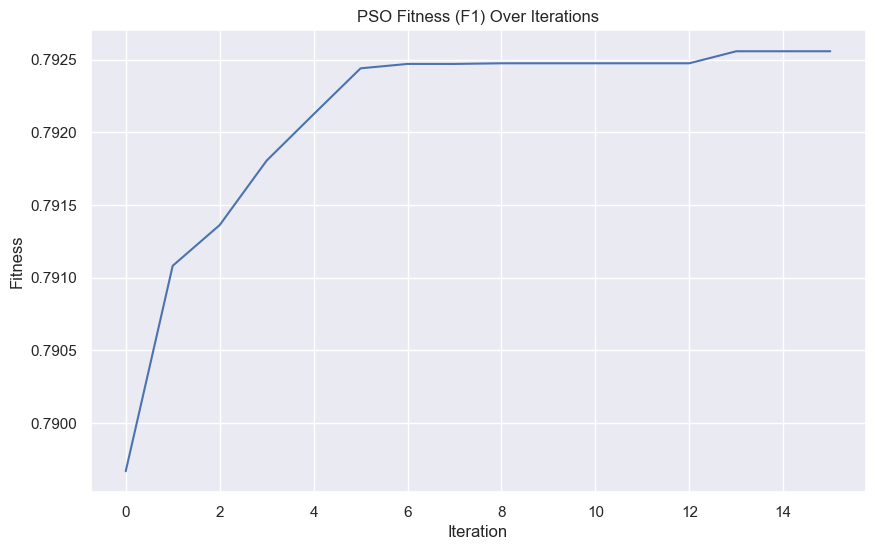

In [164]:
# plot pso data
pso_data = pd.read_csv('pso_data_f1.csv')
plt.figure(figsize=(10, 6))
plt.plot(pso_data['Iteration'], pso_data['Fitness'])
plt.title('PSO Fitness (F1) Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.show()

In [115]:
# Grid Search 
param_grid, train_best_grid, test_best_grid = grid_search_nd_modified(
    data, 
    test_bounds, 
    swarm_size*max_iter, 
    cv_repeated_splits, 
    SEED)
print("Grid Search")
print(param_grid, train_best_grid, test_best_grid)

Fitting 16 folds for each of 256 candidates, totalling 4096 fits
Grid Search
{'colsample_bytree': np.float64(0.34), 'gamma': np.float64(1.0), 'max_depth': np.int64(8), 'reg_lambda': np.float64(8.333333333333334)} 0.7934755907499474 0.8060270837306885


#### Non-repeated

In [35]:
test_bounds = {
        # 'min_child_weight': (0,10),
        'gamma': (0,5),
        # 'n_estimators': (0,1000),
        'max_depth': (3,9),
        'reg_lambda': (5,10),
        # 'learning_rate': (1e-2,1)
        # 'subsample': (1e-4, 1),
        #'colsample_bytree': (1e-4, 1),
    }

# PSO
swarm_size = 16
max_iter = 9

In [36]:
param_pso, train_best_pso, test_best_pso = pso_xgboost(
    data, 
    fitness_function, 
    cv_splits, 
    SEED, 
    test_bounds, 
    swarm_size, 
    max_iter)
print("PSO")
print(param_pso, train_best_pso, test_best_pso)

PSO
[0.8641368779597451, 7, 8.537977197649619] 0.7913902844137276 0.7980088071989279


In [37]:
# Grid Search 
param_grid, train_best_grid, test_best_grid = grid_search_nd_modified(
    data, 
    test_bounds, 
    swarm_size*max_iter, 
    cv_splits, 
    SEED)
print("Grid Search")
print(param_grid, train_best_grid, test_best_grid)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Grid Search
{'gamma': np.float64(1.0), 'max_depth': np.int64(7), 'reg_lambda': np.float64(5.0)} 0.7918047386994317 0.7990026850786345


### Feature Selection

In [ ]:
# Grid Search 
feature_importance = True
param_grid, train_best_grid, test_best_grid, sorted_importances = grid_search_nd_modified(data, test_bounds, swarm_size*max_iter, cv_splits, SEED, feature_importance)

print("Grid Search Results:")
print(param_grid, train_best_grid, test_best_grid)

In [ ]:
feature_names = X.columns
mapped_importances = {feature_names[int(f[1:])]: imp for [f, imp] in sorted_importances}
for key, value in mapped_importances.items():
	print(f"Feature: {key}, Importance (Gain): {value}")

In [ ]:
list(mapped_importances.keys())[0:11]

In [ ]:
X_feature_select = X[X.columns.intersection(list(mapped_importances.keys())[0:11])]
X_feature_select.head()

In [ ]:
X_feature_select 

In [ ]:
# Set global seeds for reproducibility
SEED = 40

# Split train/test with a random state
X_train, X_test, y_train, y_test = train_test_split(X_feature_select, y, random_state=SEED, train_size=0.8)

## Normalized Data
# Initialize and use StandardScaler to normalize the data
scaler = StandardScaler()
X_feature_select_partial_normalized_train = scaler.fit_transform(X_train[['BMI', 'Age']])     # Fit and transform the training data
X_feature_select_partial_normalized_test = scaler.transform(X_test[['BMI', 'Age']])           # Only transform the test data.

X_feature_select_normalized_train = X_train.copy()
X_feature_select_normalized_train[['BMI', 'Age']] = X_feature_select_partial_normalized_train      
X_feature_select_normalized_test = X_test.copy()
X_feature_select_normalized_test[['BMI', 'Age']] = X_feature_select_partial_normalized_test  

# Generate CV splits once (to reuse the same splits for both methods)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
cv_splits_feature_select = list(cv.split(X_feature_select_normalized_train, y_train))  # X, y are your data and labels
print("cv_splits")
print(cv_splits_feature_select)

# Define the params 
data_feature_select = (X_feature_select_normalized_train, X_feature_select_normalized_test, y_train, y_test)
test_bounds = {
        # 'min_child_weight': (0,10),
        'gamma': (0,5),
        'n_estimators': (0,500),
        'max_depth': (3,12),
        'lambda': (0,10),
        # 'learning_rate': (1e-2,1)
        # 'subsample': (1e-4, 1),
        # 'colsample_bytree': (1e-4, 1),
    }

# PSO
swarm_size = 9
max_iter = 16

In [ ]:
# Grid Search 
param_grid_fs, train_best_grid_fs, test_best_grid_fs = grid_search_nd_modified(data_feature_select, test_bounds, swarm_size*max_iter, cv_splits, SEED)
print("Grid Search")
print(param_grid_fs, train_best_grid_fs, test_best_grid_fs)

In [ ]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(XGBClassifier(learning_rate=0.1,  **param_grid_fs), X_feature_select_normalized_train, y_train, cv=cv_splits_feature_select, scoring='f1')

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure()
plt.title("Learning Curves (XGBoost)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
				 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
				 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Interpretation
print("Training scores mean:", train_scores_mean)
print("Cross-validation scores mean:", test_scores_mean)

if train_scores_mean[-1] < 0.8 and test_scores_mean[-1] < 0.8:
	print("The model is underfitting (high bias).")
elif train_scores_mean[-1] > 0.9 and test_scores_mean[-1] < 0.8:
	print("The model is overfitting (high variance).")
else:
	print("The model has a good fit.")

# Default

In [38]:
xg = XGBClassifier()
xg.fit(X_normalized_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [39]:
y_train_predictions = xg.predict(X_normalized_train)
f1_train = f1_score(y_train, y_train_predictions)

print(f1_train)

0.8354344453064391


In [40]:
y_test_predictions = xg.predict(X_normalized_test)
f1_test = f1_score(y_test, y_test_predictions)

print(f1_test)

0.7969348659003831


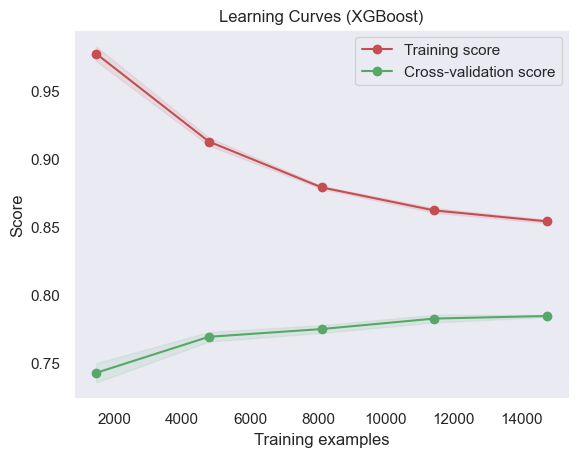

Training scores mean: [0.97694875 0.91242783 0.87881562 0.86189881 0.85387191]
Cross-validation scores mean: [0.74268625 0.76914334 0.77484249 0.78252667 0.78442059]
The model has a good fit.


In [41]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(xg, X_normalized_train, y_train, cv=cv_splits, scoring='f1')

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure()
plt.title("Learning Curves (XGBoost)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
				 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
				 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Interpretation
print("Training scores mean:", train_scores_mean)
print("Cross-validation scores mean:", test_scores_mean)

if train_scores_mean[-1] < 0.8 and test_scores_mean[-1] < 0.8:
	print("The model is underfitting (high bias).")
elif train_scores_mean[-1] > 0.9 and test_scores_mean[-1] < 0.8:
	print("The model is overfitting (high variance).")
else:
	print("The model has a good fit.")

# Store data

In [42]:
import time 

In [129]:
data_points = 30
swarm_size = 16
max_iter = 16
test_bounds = {
        'gamma': (1,5),
        'max_depth': (5,8),
        'reg_lambda': (5,10),
        'colsample_bytree': (1e-2, 1),
}
pso_data = []
grid_data = []

for i in range(data_points): 
    print("Data point: ", i)
    SEED = np.random.randint(0, 1000)

    # Split train/test with a random state
    X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, random_state=SEED, train_size=0.8)

    ## Normalized Data
    # Initialize and use StandardScaler to normalize the data
    scaler = StandardScaler()
    X_normalized_train = scaler.fit_transform(X_train)     # Fit and transform thr training data
    X_normalized_test = scaler.transform(X_test)           # Only transform the test data.

    # Generate CV splits once (to reuse the same splits for both methods)
    # cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    # cv_splits = list(cv.split(X_normalized_train, y_train))  # X, y are your data and labels
    cv_repeated = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=SEED)
    cv_repeated_splits = list(cv_repeated.split(X_normalized_train, y_train))  # X, y are your data and labels

    data = (X_normalized_train, X_normalized_test, y_train, y_test)

    start = time.time()
    param_pso, train_best_pso, test_best_pso = pso_xgboost(data, fitness_function, cv_repeated_splits, SEED, test_bounds, swarm_size, max_iter)
    end = time.time()
    pso_data.append([param_pso, train_best_pso, test_best_pso, SEED, end-start])

    start = time.time()
    param_grid, train_best_grid, test_best_grid = grid_search_nd_modified(data, test_bounds, swarm_size*max_iter, cv_repeated_splits, SEED)
    end = time.time()
    grid_data.append([param_grid, train_best_grid, test_best_grid, SEED, end-start])

Data point:  0
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  1
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  2
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  3
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  4
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  5
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  6
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  7
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  8
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  9
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  10
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  11
Fitting 9 folds for each of 256 candidates, totalling 2304 fits
Data point:  12
Fitting 9 folds for each of 256 ca

In [130]:
with open('pso_4p_' + 'f1' + '_' + str(swarm_size) + '_' + str(max_iter) + '.csv', 'w') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(["param", "train", "test", "seed", "time"])
    for i in range(len(pso_data)):
        csv_writer.writerow(pso_data[i])

with open('grid_4p_' + 'f1' + '_' + str(swarm_size) + '_' + str(max_iter) + '.csv', 'w') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(["param", "train", "test", "seed", "time"])
    for i in range(len(grid_data)):
        csv_writer.writerow(grid_data[i])

# Hypothesis Testing 

## 16 x 16

In [119]:
from scipy import stats

In [169]:
grid_f1 = pd.read_csv(r'grid_4p_f1_16_16.csv')
pso_f1 = pd.read_csv(r'pso_4p_f1_16_16.csv')

In [132]:
# Perform the t-test:
t_stat, p_value = stats.ttest_rel(grid_f1['train'], pso_f1['train'], alternative='less')

# Interpret the results:
alpha = 0.05
if p_value < alpha:
    print("p_value: " + str(p_value) + "\nReject the null hypothesis; there is a significant difference between PSO and GridSearch train results (GridSearch < PSO in terms of f1)")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between PSO and GridSearch")

p_value: 2.7660714963642216e-06
Reject the null hypothesis; there is a significant difference between PSO and GridSearch train results (GridSearch < PSO in terms of f1)


In [133]:
# Perform the t-test:
t_stat, p_value = stats.ttest_rel(grid_f1['test'], pso_f1['test'], alternative='less')

# Interpret the results:
alpha = 0.05
if p_value < alpha:
    print("p_value: " + str(p_value) + "\nReject the null hypothesis; there is a significant difference between PSO and GridSearch test results (GridSearch < PSO)")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between PSO and GridSearch")
    print(p_value)

p_value: 6.951995942121815e-18
Reject the null hypothesis; there is a significant difference between PSO and GridSearch test results (GridSearch < PSO)


In [136]:
temp = grid_f1['test'] - pso_f1['test']
temp 
count = 0 
for i in temp: 
	if i > 0: 
		count += 1
count

0

In [137]:
# Perform the t-test:
t_stat, p_value = stats.ttest_rel(grid_f1['time'], pso_f1['time'], alternative='less')

# Interpret the results:
alpha = 0.05
if p_value < alpha:
    print("p_value: " + str(p_value) + "\nReject the null hypothesis; there is a significant difference between PSO and GridSearch tuning time (GridSearch < PSO)")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between PSO and GridSearch")
    print(p_value)

p_value: 1.722766742842392e-14
Reject the null hypothesis; there is a significant difference between PSO and GridSearch tuning time (GridSearch < PSO)


## 9 x 9 

In [138]:
grid_f1_9x9 = pd.read_csv(r'grid_4p_f1_9_9.csv')
pso_f1_9x9 = pd.read_csv(r'pso_4p_f1_9_9.csv')

In [139]:
# Perform the t-test:
t_stat, p_value = stats.ttest_rel(grid_f1_9x9['train'], pso_f1_9x9['train'], alternative='less')

# Interpret the results:
alpha = 0.05
if p_value < alpha:
    print("p_value: " + str(p_value) + "\nReject the null hypothesis; there is a significant difference between PSO and GridSearch train results (GridSearch < PSO in terms of f1)")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between PSO and GridSearch")

p_value: 0.0003645305870798159
Reject the null hypothesis; there is a significant difference between PSO and GridSearch train results (GridSearch < PSO in terms of f1)


In [140]:
# Perform the t-test:
t_stat, p_value = stats.ttest_rel(grid_f1_9x9['test'], pso_f1_9x9['test'], alternative='less')

# Interpret the results:
alpha = 0.05
if p_value < alpha:
    print("p_value: " + str(p_value) + "\nReject the null hypothesis; there is a significant difference between PSO and GridSearch test results (GridSearch < PSO)")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between PSO and GridSearch")
    print(p_value)

p_value: 4.217945517182343e-20
Reject the null hypothesis; there is a significant difference between PSO and GridSearch test results (GridSearch < PSO)


# Mean and Std

## Train

In [170]:
grid_f1_9x9['train'].mean(), pso_f1_9x9['train'].mean()

(np.float64(0.7943697693819722), np.float64(0.7950351479816221))

In [171]:
grid_f1_9x9['train'].std(), pso_f1_9x9['train'].std()

(np.float64(0.0017930329402712998), np.float64(0.0018467058509095996))

In [172]:
grid_f1['train'].mean(), pso_f1['train'].mean()

(np.float64(0.7951215219242117), np.float64(0.7956905616566939))

In [173]:
grid_f1['train'].std(), pso_f1['train'].std()

(np.float64(0.0015299623080677076), np.float64(0.0014590388116120867))

## Test

In [165]:
grid_f1_9x9['test'].mean(), pso_f1_9x9['test'].mean()

(np.float64(0.7953200707859427), np.float64(0.8071368294153103))

In [166]:
grid_f1_9x9['test'].std(), pso_f1_9x9['test'].std()

(np.float64(0.006358129138699068), np.float64(0.00657727669596481))

In [167]:
grid_f1['test'].mean(), pso_f1['test'].mean()

(np.float64(0.7959322084164691), np.float64(0.8063291139240506))

In [168]:
grid_f1['test'].std(), pso_f1['test'].std()

(np.float64(0.004404150101297959), np.float64(0.004470758822299197))